# Progress Review

In [ ]:
# Download necessary files
# pip install langchain pacmap d2l sentence-transformers
# gdown 1qrLC-KxrlhO4iYSUITyPAK5KOpfVS7bq # the model
# unzip deliverable.zip

## Architecture
Below is shown a diagram that describes how the application is organised. There are two stages involved:
- the first process creates a vector database that is used for retrieving useful information relevant to a given query;
- the second process uses this information and appends it to prompt used by the LLM to answer to given tasks.


<img src="seq_diagram.png" alt="drawing" width="960"/>

## Necessary imports

In [22]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import pacmap
import numpy as np
import plotly.express as px
import pandas as pd
import pickle
from transformers import AutoTokenizer
import matplotlib.pyplot as plt 
import re
import os
import json
import glob
import random
# Set pandas to display full text in columns
pd.set_option('display.max_colwidth', 120)

## Load previously generated data
- the tokenizer defined below was designed to be used for the manipulation of documents containing code. [Click here]((flax-sentence-embeddings/st-codesearch-distilroberta-base)) for more details.

In [46]:
EMBEDDING_MODEL_NAME = "flax-sentence-embeddings/st-codesearch-distilroberta-base"

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.load_local(
    "deliverable/faiss_db", # faiss_db
    embedding_model,
    distance_strategy=DistanceStrategy.COSINE,
    allow_dangerous_deserialization=True
)

with open('deliverable/documents.pkl', 'rb') as f:
    docs_processed = pickle.load(f)

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)

## Utility functions

In [47]:
# Utility functions
def visualise_query_distrib(user_query):
    query_vector = embedding_model.embed_query(user_query)

    embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

    embeddings_2d = [
        list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0]) for idx in range(len(docs_processed))
    ] + [query_vector]

    # fit the data (The index of transformed data corresponds to the index of the original data)
    documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

    df = pd.DataFrame.from_dict(
        [
            {
                "x": documents_projected[i, 0],
                "y": documents_projected[i, 1],
                "source": docs_processed[i].metadata["source"].split("/")[1],
                "extract": docs_processed[i].page_content[:100] + "...",
                "symbol": "circle",
                "size_col": 4,
            }
            for i in range(len(docs_processed))
        ]
        + [
            {
                "x": documents_projected[-1, 0],
                "y": documents_projected[-1, 1],
                "source": "User query",
                "extract": user_query,
                "size_col": 100,
                "symbol": "star",
            }
        ]
    )

   # visualize the embedding
    fig = px.scatter(
        df,
        x="x",
        y="y",
        color="source",
        hover_data="extract",
        size="size_col",
        symbol="symbol",
        color_discrete_map={"User query": "black"},
        width=1000,
        height=700,
    )
    fig.update_traces(
        marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
        selector=dict(mode="markers"),
    )
    fig.update_layout(
        legend_title_text="<b>Chunk source</b>",
        title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
    )
    fig.show()


def print_test_settings(experiment):
    settings = experiment['test_settings'][0]
    parts = re.findall(r":([^:_]*)(?:_|$)", settings)
    
    print(f"Number of samples in the experiment: {len(experiment)}")
    print("Below is the test configuration:")
    print(f"Chunk size: {parts[0]}")
    print(f"Embedding used: {parts[1]}")
    print(f"Rerank used: {parts[2]}")
    print(f"Number of final documents added to the context: {parts[3]}")
    print(f"Number of retrieved documents: {parts[4]}")
    print(f"Evaluated model: {parts[5]}")
    print(f"Evaluator model: {parts[6][:-5]}")



# Visualization
## The distribution of tokens in the dataset

The chunk size defined below is the maximum chunk size supported by this tokenizer.

Using encoder defined at flax-sentence-embeddings/st-codesearch-distilroberta-base.
Chunk size: 128.


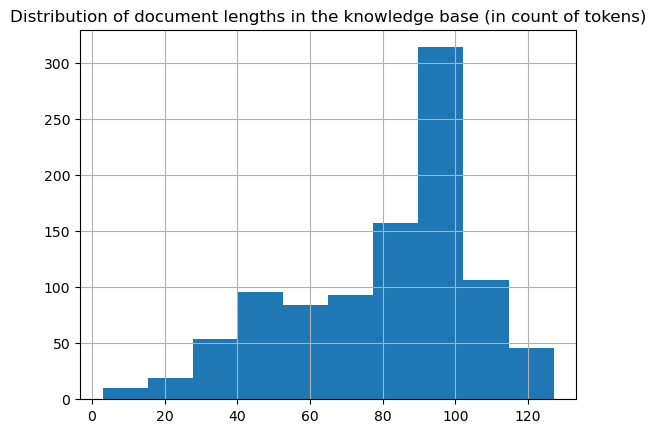

In [48]:
CHUNK_SIZE = 128

print(f"Using encoder defined at {EMBEDDING_MODEL_NAME}.")
print(f"Chunk size: {CHUNK_SIZE}.")
lengths = [
    len(tokenizer.encode(doc.page_content)) for doc in docs_processed
]

fig = pd.Series(lengths).hist()
plt.title(
    "Distribution of document lengths in the knowledge base (in count of tokens)"
)
plt.show()

## Projection of the Chunk Embeddings via PaCMAP

In [49]:
user_query = "How to kill 1 zombie?"

visualise_query_distrib(user_query)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/atomwalk12/anaconda3/envs/questllama/lib/python3.9/site-packages/pacmap/pacmap.py:828: UserWarning:




In [51]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='How to kill 1 zombie?'...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



==================================Top document==================================
await killMob(bot, "skeleton", 300);
      bot.chat("Killed 1 skeleton.");
    }
  } else {
    bot.chat("Could not find a skeleton.");
  }
}
==================================Metadata==================================
{'source': '/home/atomwalk12/repos/QuestLlama/questllama/skill_library/trial6/skill/code/killOneSkeletonWithBow.js', 'start_index': 1067}


# Experiments
Below are the parameters used to carry out the experiments. They are ordered by their importance and there are shown some modifications which I would also like to carry out.
- Use another evaluator: WizardLM, WizardCoder, Llama 3.

In [218]:
experiments = {}
for file in glob.glob("./output/*.json"):
    if os.path.isfile(file):
        with open(file, "r") as f:
            experiment_data = json.load(f)
        df = pd.DataFrame(experiment_data)
      
        key = f"rerank={'rerank:True' in file}"
        experiments[key] = df

for i, experiment in enumerate(experiments.values()):
    print(f"\n================= Experiment {i} =================")
    print_test_settings(experiment)



================= Experiment 0 =================
Number of samples in the experiment: 100
Below is the test configuration:
Chunk size: 128
Embedding used: flax-sentence-embeddings~st-codesearch-distilroberta-base
Rerank used: True
Number of final documents added to the context: 3
Number of retrieved documents: 30
Evaluated model: deepseek-coder~33b-instruct-q5~K~M
Evaluator model: gattipg~prometheus~13b-v1.0-Q

================= Experiment 1 =================
Number of samples in the experiment: 48
Below is the test configuration:
Chunk size: 128
Embedding used: flax-sentence-embeddings~st-codesearch-distilroberta-base
Rerank used: False
Number of final documents added to the context: 3
Number of retrieved documents: 30
Evaluated model: deepseek-coder~33b-instruct-q5~K~M
Evaluator model: gattipg~prometheus~13b-v1.0-Q


In [219]:
print("Data generated for each experiment:")
experiments['rerank=True'].info()

Data generated for each experiment:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column                                            Non-Null Count  Dtype 
---  ------                                            --------------  ----- 
 0   question                                          100 non-null    object
 1   true_answer                                       100 non-null    object
 2   source_doc                                        100 non-null    object
 3   generated_answer                                  100 non-null    object
 4   retrieved_docs                                    100 non-null    object
 5   description                                       100 non-null    object
 6   test_settings                                     100 non-null    object
 7   eval_score_gattipg/prometheus:13b-v1.0-Q5_K_M     100 non-null    object
 8   eval_feedback_gattipg/prometheus:13b-v1.0-Q5_K_M  100 non-null    object
dty

In [226]:
rerank = False # can be true or false to retrieve the corresponding experiment

# Choose a random problem from the experiment defined above
experiment = experiments[f'rerank={rerank}']

# Select a random index
idx = random.randint(0, len(experiment) - 1)

print(f"\n================= Task index: {idx} =================")
print(f"Question: {experiment['question'][idx]}")

print("\n================= Generated evaluation =================")
print(experiment['generated_answer'][idx])

print("\n================= Ideal solution =================")
print(experiment['true_answer'][idx])

print("\n================= Generated evaluation =================")
print(experiment['eval_feedback_gattipg/prometheus:13b-v1.0-Q5_K_M'][idx])

print(f"\nEvaluation score: {experiment['eval_score_gattipg/prometheus:13b-v1.0-Q5_K_M'][idx]}")


================= Task index: 14 =================
Question: How to kill three chickens in Minecraft?

================= Generated evaluation =================
Explain: The provided code snippets are not complete and do not fulfill the task of killing three chickens in Minecraft. They only provide examples for exploring until finding a chicken but do not actually kill it. Also, they do not handle inventory management or error checking which is crucial for completing tasks in Minecraft.

Plan: 
1) First, we need to equip a weapon (preferably a sword) to kill the chickens. We can check if the bot has a stone_sword or wooden_sword in its inventory and equip it. If not, we should stop the function as there is no way to proceed.
2) After equipping the weapon, we need to find three chickens. We can use the `exploreUntil` function for this purpose. The direction of exploration should be randomized every time to avoid getting stuck in a loop.
3) Once we have found a chicken, we can attack it 

## Distribution of the votes

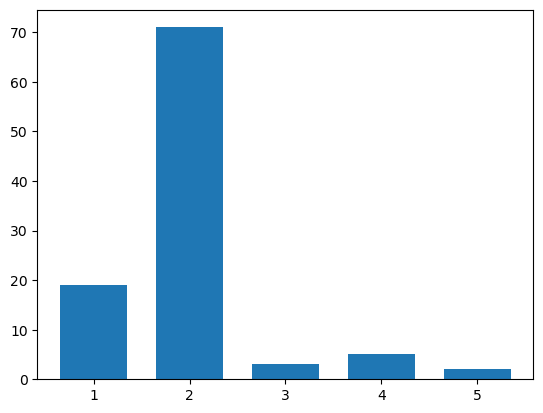

Total number of samples in the experiment 100


In [199]:
rerank = True # can be true or false to retrieve the corresponding experiment
experiment = experiments[f'rerank={rerank}']

scores =  [int(score) for score in experiment['eval_score_gattipg/prometheus:13b-v1.0-Q5_K_M']]

# Calculate the minimum and maximum scores, expanded by 0.5 on each side for proper binning
min_score = min(scores) - 0.5
max_score = max(scores) + 0.5

# Generate bin edges from min to max with each bin size of 1
bins = np.arange(min_score, max_score + 1, 1)

# Plotting the histogrm
plt.hist(scores, bins=bins, rwidth=0.7)
plt.xticks(np.arange(min(scores), max(scores) + 1))

# Display the plot
plt.show()
print(f"Total number of samples in the experiment {len(experiment)}")

In [194]:
evaluator_name = "gattipg/prometheus:13b-v1.0-Q5_K_M"

# Concatenate all DataFrames stored in the dictionary
result = pd.concat(experiments.values(), keys=experiments.keys())

score_col_name = f"eval_score_{evaluator_name}"
result[score_col_name] = result[score_col_name].apply(lambda x: int(x) if isinstance(x, str) else 1)
result[score_col_name] = (result[score_col_name] - 1) / 4

# Group by the outer index, which corresponds to the keys used in experiments dictionary
average_scores = result.groupby(level=0)[score_col_name].mean()

average_scores.sort_values()
scaled_values = pd.Series(average_scores * 100)
scaled_values

# Display the bar chart
fig = px.bar(
    scaled_values,
    color=scaled_values,
    labels={
        "value": "Accuracy",
        "settings": "Configuration",
    },
    color_continuous_scale="bluered",
)
fig.update_layout(
    width=1000,
    height=600,
    barmode="group",
    yaxis_range=[0, 100],
    title="<b>Accuracy of different RAG configurations</b>",
    xaxis_title="RAG settings",
    font=dict(size=15),
)
fig.layout.yaxis.ticksuffix = "%"
fig.update_coloraxes(showscale=False)
fig.update_traces(texttemplate="%{y:.1f}", textposition="outside")
fig.show()
